In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install --upgrade transformers
!pip install tensorflow-io
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━

In [3]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtype

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import torch
import tensorflow as tf
import keras
from tensorflow.python.keras import activations, optimizers, losses
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score
import transformers
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification

In [5]:
print(transformers.__version__) # make sure the version is 4.39, else optimizer would have error

4.40.0


In [6]:
def load_data(filepath):
  data = pd.read_csv(filepath)
  print(data.head())

  return data

In [7]:
data = load_data("/content/drive/MyDrive/MDS_FYP/Data/cleaned_data.csv")

                                                text  label
0  ['ex', 'wife', 'threaten', 'suiciderec', 'left...      1
1  ['weird', 'dont', 'get', 'affect', 'compliment...      0
2  ['final', 'almost', 'never', 'hear', 'bad', 'y...      0
3  ['need', 'helpjust', 'help', 'im', 'cri', 'hard']      1
4  ['im', 'losthello', 'name', 'adam', 'ive', 'st...      1


In [8]:
# separate training and holdout set
training_data, holdout_data = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
def plot_scores_across_folds(scores_list, eval_metrics, output_file=None):
    num = len(scores_list)
    plt.plot(scores_list, marker="o", label=eval_metrics)
    plt.xlabel("Fold")
    plt.ylabel(f"{eval_metrics}")
    plt.title(f"{eval_metrics} across Folds")
    plt.legend()
    plt.xticks(range(0, num), [str(i+1) for i in range(num)])
    plt.show()

    if output_file:
        plt.savefig(output_file)

In [10]:
def pred_performance_measure(model, val_dataset, labels_val):
    # perform prediction on the validation dataset
    predictions = model.predict(val_dataset)
    predicted_probs = predictions[0][:, 0] # use the first output and raw logits directly
    predicted_labels = (predicted_probs >= 0.5).astype(int) # convert probability into binary labels

    # create confusion matrix
    confusion_matrix_data = tf.math.confusion_matrix(labels_val, predicted_labels)
    plt.figure(figsize=(5,3))
    sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

    # calculate row sums (actual label counts) and column sums (predicted label counts)
    row_cnt = confusion_matrix_data.numpy().sum(axis=1)
    col_cnt = confusion_matrix_data.numpy().sum(axis=0)
    confusion_matrix_perc = (confusion_matrix_data/row_cnt[:, np.newaxis])*100
    plt.figure(figsize=(5,3))
    sns.heatmap(confusion_matrix_perc, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix (%)")
    plt.show()

    accuracy = accuracy_score(labels_val, predicted_labels)
    precision = precision_score(labels_val, predicted_labels)
    recall = recall_score(labels_val, predicted_labels)
    f1 = f1_score(labels_val, predicted_labels)
    roc_auc = roc_auc_score(labels_val, predicted_probs)

    # create and display ROC AUC plot
    fpr, tpr, _ = roc_curve(labels_val, predicted_probs)
    plt.figure(figsize=(5,3))
    plt.plot(fpr, tpr, label="ROC Curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

In [11]:
def calc_avg_cv(accuracy_scores_list, precision_scores_list, recall_scores_list, f1_scores_list, roc_auc_values, n_folds):
    """
    calculate the average value after n-fold of cross validation
    """
    final_accuracy = sum(accuracy_scores_list) / n_folds
    final_precision = sum(precision_scores_list) / n_folds
    final_recall = sum(recall_scores_list) / n_folds
    final_f1 = sum(f1_scores_list) / n_folds
    final_roc_auc = sum(roc_auc_values) / n_folds

    return final_accuracy, final_precision, final_recall, final_f1, final_roc_auc

In [12]:
def holdout_performance_measure(model, tokenizer, holdout_set):
    encodings = {
        "input_ids_holdout": [],
        "attention_masks_holdout": []
    }

    for text_row in holdout_set["text"]:
        text_str = " ".join(text_row)
        tokens = tokenizer(text_row, truncation=True, padding="max_length", max_length=64, return_tensors="tf")
        encodings["input_ids_holdout"].append(tokens["input_ids"])
        encodings["attention_masks_holdout"].append(tokens["attention_mask"])

    input_ids_holdout = np.array(encodings["input_ids_holdout"])
    attention_masks_holdout = np.array(encodings["attention_masks_holdout"])
    input_ids_holdout = np.squeeze(input_ids_holdout, axis=1)
    attention_masks_holdout = np.squeeze(attention_masks_holdout, axis=1)

    holdout_labels = np.array(holdout_data["label"])

    holdout_predictions = model.predict([input_ids_holdout, attention_masks_holdout])
    holdout_proba = holdout_predictions.logits[:, 0]
    holdout_probabilities = tf.nn.sigmoid(holdout_proba).numpy()
    holdout_predictions_class = (holdout_proba > 0.5).astype(int)

    accuracy_holdout = accuracy_score(holdout_labels, holdout_predictions_class)
    precision_holdout = precision_score(holdout_labels, holdout_predictions_class)
    recall_holdout = recall_score(holdout_labels, holdout_predictions_class)
    f1_holdout = f1_score(holdout_labels, holdout_predictions_class)
    roc_auc_holdout = roc_auc_score(holdout_labels, holdout_probabilities)

    return accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout

In [13]:
def save_result_to_csv(accuracy, precision, recall, f1_score, roc_auc, csv_filepath):
    if os.path.exists(csv_filepath):
        existing_df = pd.read_csv(csv_filepath)
    else:
        existing_df = pd.DataFrame()

    new_row = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1_Score": [f1_score],
        "ROC AUC": [roc_auc]
    })

    existing_df = pd.concat([existing_df, new_row], ignore_index=True)
    existing_df.to_csv(csv_filepath, index=False)

    return existing_df

# ALBert

In [14]:
BATCH_SIZE = 16
N_FOLDS = 5
N_EPOCHS = 4
LEARNING_RATE = 2e-5
input_ids = []
attention_masks = []

labels = np.array(training_data["label"])

MODEL_NAME = "albert-base-v2"
tokenizer = AlbertTokenizer.from_pretrained(MODEL_NAME)
encodings = {
    "input_ids": [],
    "attention_mask": []
}

for text_row in training_data["text"]:
    text_str = " ".join(text_row)
    tokens = tokenizer(text_row, truncation=True, padding="max_length", max_length=64, return_tensors="tf")
    input_ids.append(tokens["input_ids"])
    attention_masks.append(tokens["attention_mask"])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [15]:
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: (185659, 1, 64)
Attention Masks shape: (185659, 1, 64)
Labels shape: (185659,)


In [16]:
input_ids = np.squeeze(input_ids, axis=1)
attention_masks = np.squeeze(attention_masks, axis=1)
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: (185659, 64)
Attention Masks shape: (185659, 64)
Labels shape: (185659,)


In [17]:
training_accuracies = []
training_losses = []
val_accuracies = []
val_losses = []
accuracy_scores_list = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
roc_auc_values = []

input_data = np.array(list(zip(input_ids, attention_masks, labels)), dtype=object)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1/5
Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9283/9283 [==============================] - 1058s 108ms/step - loss: 0.3519 - accuracy: 0.8288 - val_loss: 0.1876 - val_accuracy: 0.9288
Epoch 2/4
9283/9283 [==============================] - 994s 107ms/step - loss: 0.1783 - accuracy: 0.9309 - val_loss: 0.1661 - val_accuracy: 0.9350
Epoch 3/4
9283/9283 [==============================] - 987s 106ms/step - loss: 0.1448 - accuracy: 0.9442 - val_loss: 0.1407 - val_accuracy: 0.9449
Epoch 4/4
9283/9283 [==============================] - 990s 107ms/step - loss: 0.1214 - accuracy: 0.9544 - val_loss: 0.1392 - val_accuracy: 0.9463


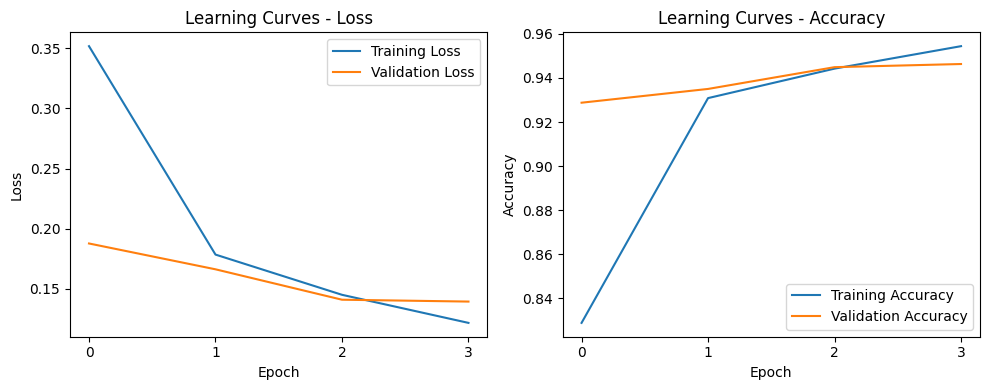

2321/2321 [==============================] - 116s 47ms/step


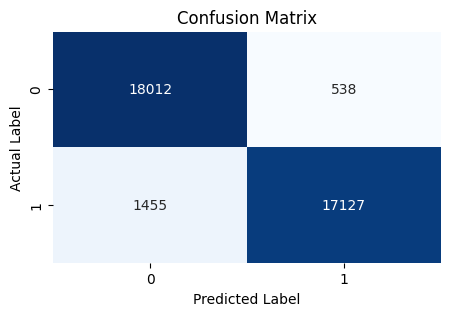

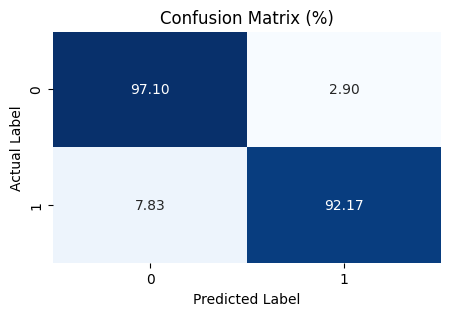

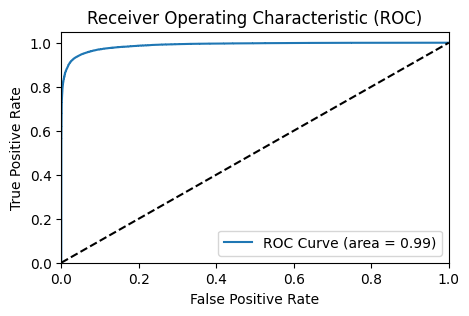

Fold 2/5
Epoch 1/4
9283/9283 [==============================] - 992s 107ms/step - loss: 0.1171 - accuracy: 0.9555 - val_loss: 0.1164 - val_accuracy: 0.9544
Epoch 2/4
9283/9283 [==============================] - 992s 107ms/step - loss: 0.0988 - accuracy: 0.9630 - val_loss: 0.1124 - val_accuracy: 0.9593
Epoch 3/4
9283/9283 [==============================] - 992s 107ms/step - loss: 0.0825 - accuracy: 0.9695 - val_loss: 0.1133 - val_accuracy: 0.9573
Epoch 4/4
9283/9283 [==============================] - 988s 106ms/step - loss: 0.0675 - accuracy: 0.9755 - val_loss: 0.1300 - val_accuracy: 0.9560


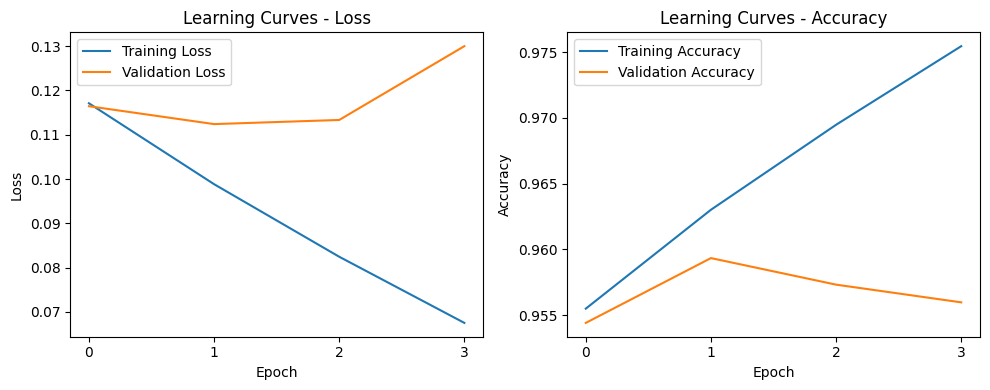

2321/2321 [==============================] - 105s 45ms/step


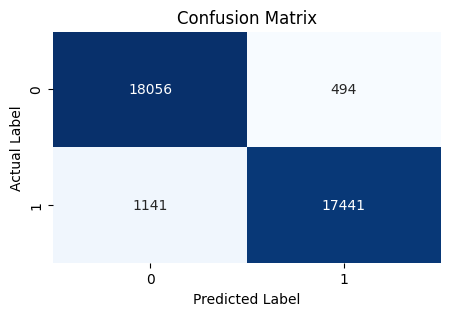

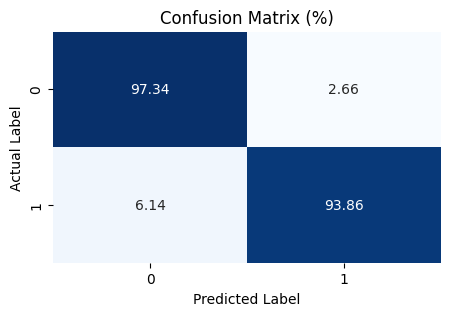

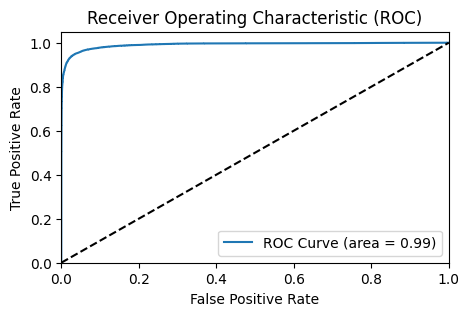

Fold 3/5
Epoch 1/4
9283/9283 [==============================] - 995s 107ms/step - loss: 0.0747 - accuracy: 0.9736 - val_loss: 0.0607 - val_accuracy: 0.9797
Epoch 2/4
9283/9283 [==============================] - 1003s 108ms/step - loss: 0.0624 - accuracy: 0.9783 - val_loss: 0.0864 - val_accuracy: 0.9663
Epoch 3/4
9283/9283 [==============================] - 993s 107ms/step - loss: 0.0549 - accuracy: 0.9806 - val_loss: 0.0784 - val_accuracy: 0.9714
Epoch 4/4
9283/9283 [==============================] - 992s 107ms/step - loss: 0.0406 - accuracy: 0.9860 - val_loss: 0.0822 - val_accuracy: 0.9724


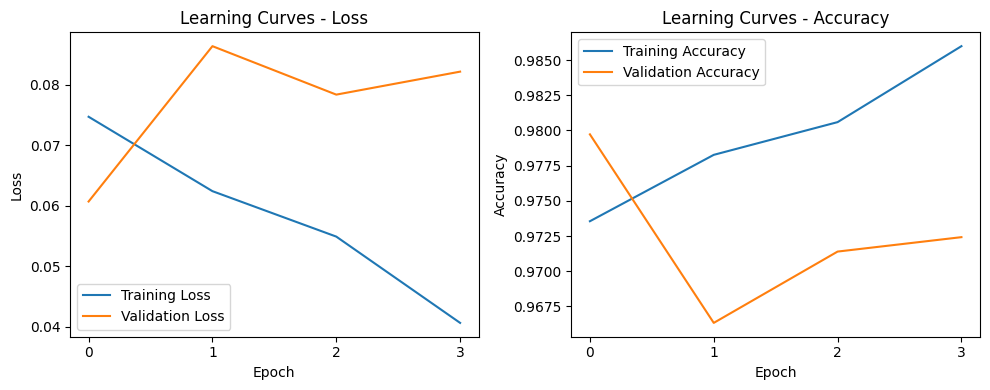

2321/2321 [==============================] - 110s 47ms/step


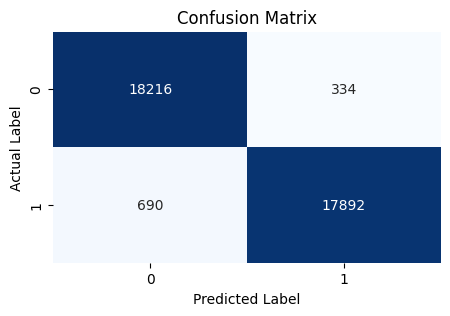

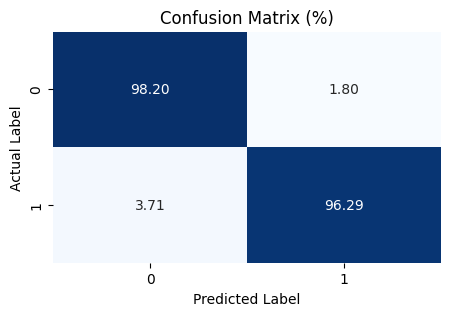

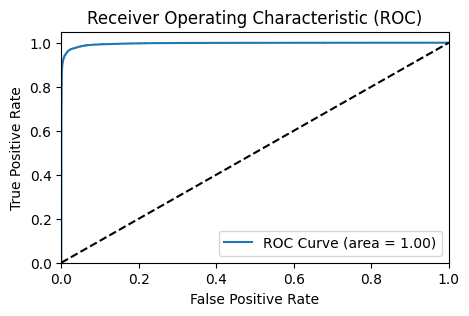

Fold 4/5
Epoch 1/4
9283/9283 [==============================] - 999s 108ms/step - loss: 0.0473 - accuracy: 0.9839 - val_loss: 0.0305 - val_accuracy: 0.9891
Epoch 2/4
9283/9283 [==============================] - 999s 108ms/step - loss: 0.0336 - accuracy: 0.9889 - val_loss: 0.0346 - val_accuracy: 0.9872
Epoch 3/4
9283/9283 [==============================] - 1000s 108ms/step - loss: 0.0260 - accuracy: 0.9912 - val_loss: 0.0443 - val_accuracy: 0.9859
Epoch 4/4
9283/9283 [==============================] - 1002s 108ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0492 - val_accuracy: 0.9834


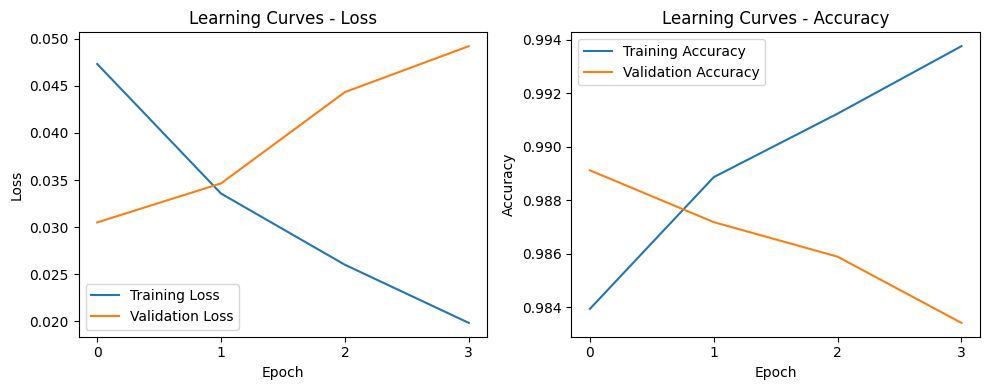

2321/2321 [==============================] - 108s 46ms/step


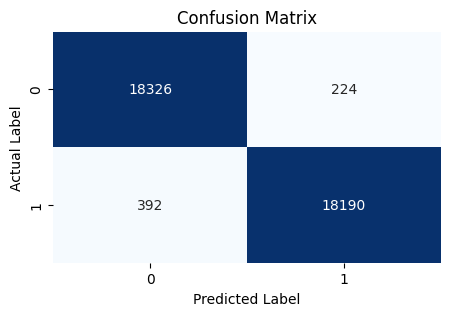

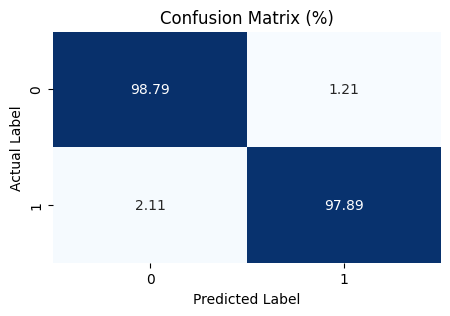

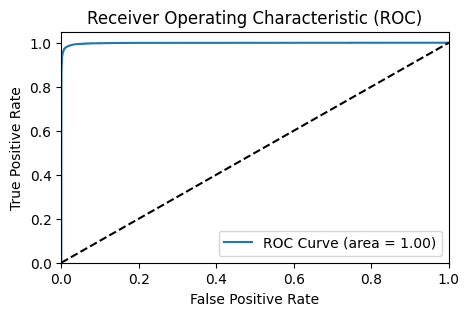

Fold 5/5
Epoch 1/4
9283/9283 [==============================] - 1005s 108ms/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.0179 - val_accuracy: 0.9946
Epoch 2/4
9283/9283 [==============================] - 1003s 108ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.0190 - val_accuracy: 0.9939
Epoch 3/4
9283/9283 [==============================] - 1053s 113ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.0340 - val_accuracy: 0.9887
Epoch 4/4
9283/9283 [==============================] - 1015s 109ms/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.0296 - val_accuracy: 0.9896


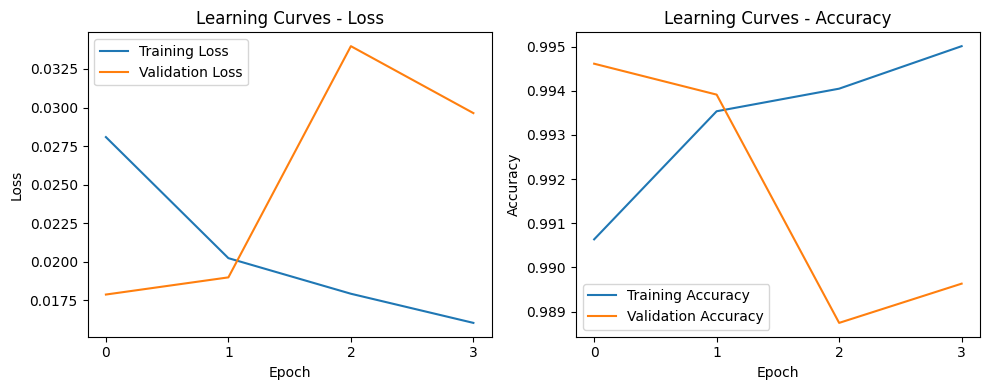

2321/2321 [==============================] - 112s 48ms/step


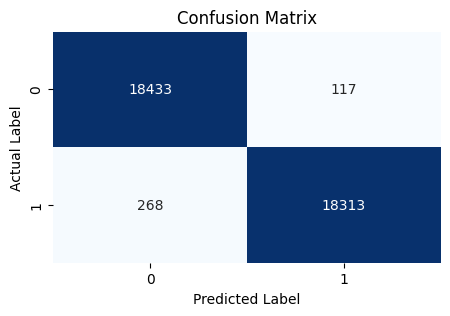

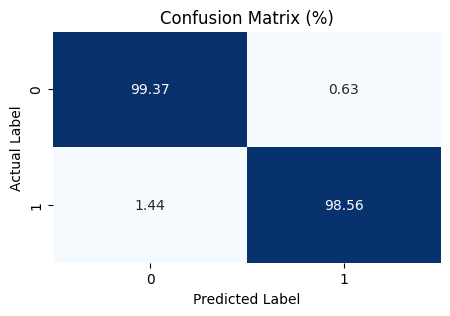

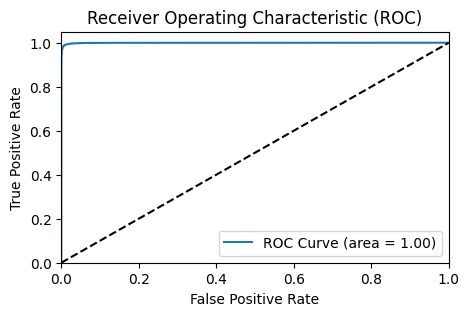

Total Training Time:  21047.10 seconds


In [18]:
model = TFAlbertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1) # binary classifcation
model.layers[-1].activation = tf.keras.activations.sigmoid # add sigmoid activation to the output layer
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True) # model outputs logits instead of probabilities
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

start_time = time.time()

# split data based on stratification of labels
for fold, (train_index, test_index) in enumerate(kfold.split(input_data, labels)):
    print(f"Fold {fold + 1}/{N_FOLDS}")

    # Split the data into train and validation sets for this fold
    input_train_fold, input_test_fold = input_data[train_index], input_data[test_index]
    input_ids_train_fold, attention_masks_train_fold, labels_train_fold = zip(*input_train_fold)
    input_ids_test_fold, attention_masks_test_fold, labels_test_fold = zip(*input_test_fold)

    # Convert the input data and labels to numpy arrays
    input_ids_train_fold = np.array(input_ids_train_fold)
    attention_masks_train_fold = np.array(attention_masks_train_fold)
    labels_train_fold = np.array(labels_train_fold)

    input_ids_test_fold = np.array(input_ids_test_fold)
    attention_masks_test_fold = np.array(attention_masks_test_fold)
    labels_test_fold = np.array(labels_test_fold)

    train_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_train_fold, attention_masks_train_fold))
    train_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_train_fold)
    train_dataset_fold = tf.data.Dataset.zip((train_input_dataset_fold, train_label_dataset_fold))

    test_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_test_fold, attention_masks_test_fold))
    test_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_test_fold)
    test_dataset_fold = tf.data.Dataset.zip((test_input_dataset_fold, test_label_dataset_fold))

    # Shuffle the training dataset
    train_dataset_fold = train_dataset_fold.shuffle(buffer_size=len(input_ids_train_fold))

    # Batch and prefetch the datasets separately
    train_dataset_fold = train_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_fold = test_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    history = model.fit(train_dataset_fold, validation_data=test_dataset_fold, epochs=N_EPOCHS)

    # plot learning curves for this fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves - Loss')
    plt.xticks(range(0, N_EPOCHS))
    plt.legend()

    # plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.xticks(range(0, N_EPOCHS))
    plt.show()

    training_accuracies.append(history.history['accuracy'])
    training_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])

    (accuracy_val, precision_val, recall_val, f1_val, roc_auc_fold) = pred_performance_measure(model, test_dataset_fold, labels_test_fold)

    accuracy_scores_list.append(accuracy_val)
    precision_scores_list.append(precision_val)
    recall_scores_list.append(recall_val)
    f1_scores_list.append(f1_val)
    roc_auc_values.append(roc_auc_fold)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time: .2f} seconds")

In [19]:
CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Training/training_metric_results_albert.csv"

if os.path.exists(CSV_FILE_PATH):
    training_df = pd.read_csv(CSV_FILE_PATH)
else:
    training_df = pd.DataFrame()

new_row = pd.DataFrame({
    "Training Accuracy": training_accuracies,
    "Training Loss": training_losses,
    "Validation Accuracy": accuracy_scores_list,
    "Validation Loss": val_losses,
    "Precision": precision_scores_list,
    "Recall": recall_scores_list,
    "F1_Score": f1_scores_list,
    "ROC AUC": roc_auc_values
})

training_df = pd.concat([training_df, new_row], ignore_index=True)
training_df.to_csv(CSV_FILE_PATH, index=False)

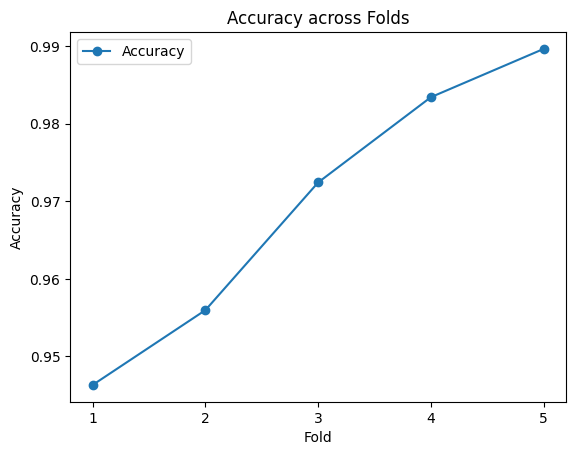

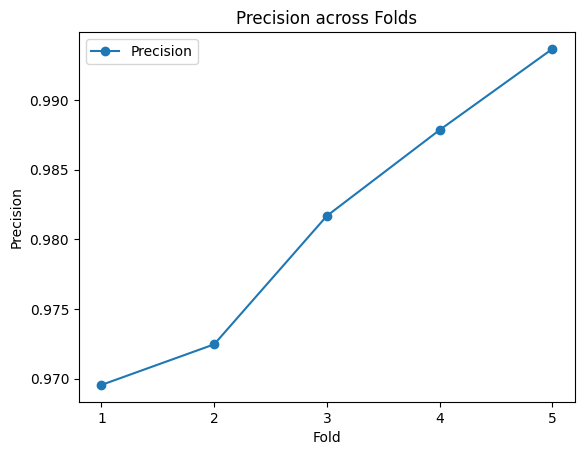

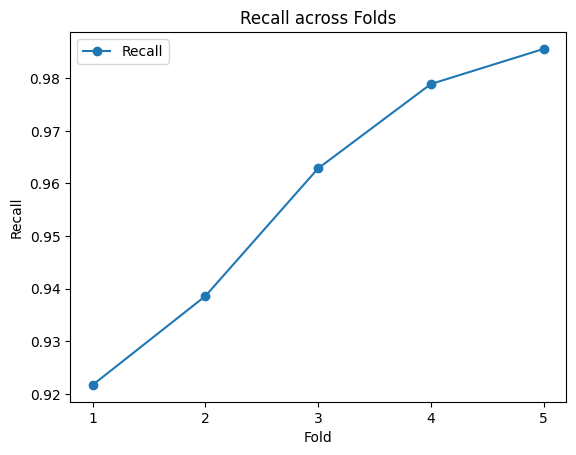

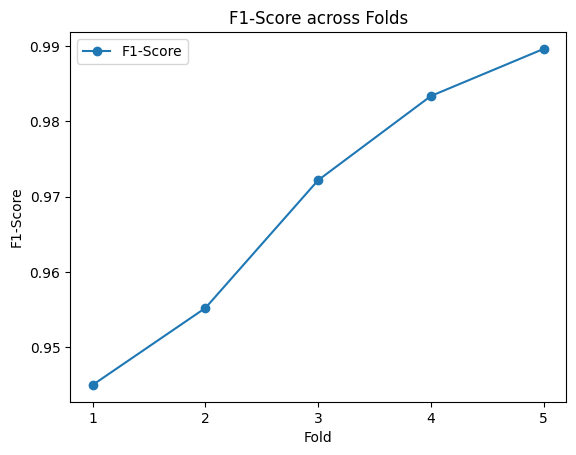

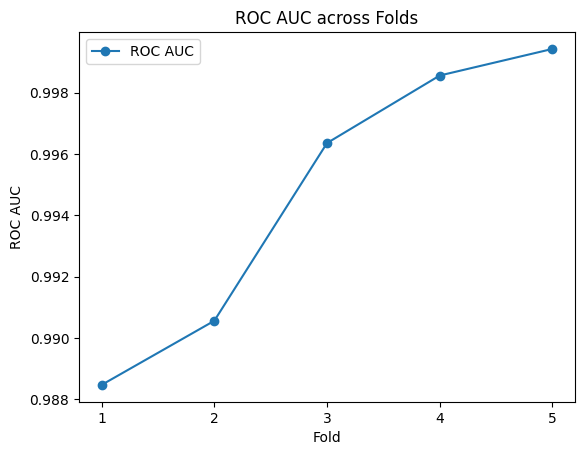

<Figure size 640x480 with 0 Axes>

In [20]:
training_accuracy_plt_filepath = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Training/training_accuracy_albert.png"
training_precision_plt_filepath = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Training/training_precision_albert.png"
training_recall_plt_filepath = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Training/training_recall_albert.png"
training_f1scores_plt_filepath = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Training/training_f1scores_albert.png"
training_rocauc_plt_filepath = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Training/training_rocauc_albert.png"

# Plot validation accuracy across folds
plot_scores_across_folds(accuracy_scores_list, "Accuracy", output_file=training_accuracy_plt_filepath)
# Plot precision across folds
plot_scores_across_folds(precision_scores_list, "Precision", output_file=training_precision_plt_filepath)
# Plot recall across folds
plot_scores_across_folds(recall_scores_list, "Recall", output_file=training_recall_plt_filepath)
# Plot F1-score across folds
plot_scores_across_folds(f1_scores_list, "F1-Score", output_file=training_f1scores_plt_filepath)
# Plot ROC AUC across folds
plot_scores_across_folds(roc_auc_values, "ROC AUC", output_file=training_rocauc_plt_filepath)

In [21]:
(avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc) = calc_avg_cv(accuracy_scores_list, precision_scores_list, recall_scores_list, f1_scores_list, roc_auc_values, N_FOLDS)

CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/CV/cv_metric_results_albert.csv"
cv_eval = save_result_to_csv(avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc, CSV_FILE_PATH)

print(f"CV Accuracy Score: {avg_accuracy}")
print(f"CV Precision Score: {avg_precision}")
print(f"CV Recall Score: {avg_recall}")
print(f"CV F1 Score: {avg_f1}")
print(f"CV ROC AUC: {avg_roc}")

CV Accuracy Score: 0.9695518131601066
CV Precision Score: 0.981032383309507
CV Recall Score: 0.957528636063549
CV F1 Score: 0.9690739343125033
CV ROC AUC: 0.9946767763766893


In [24]:
output_model_file = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Model/albert"
output_vocab_file = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Model/albertvocab.txt"

model.save_pretrained(output_model_file)
with open(output_vocab_file, "w") as vocab_file:
    vocab_file.write("\n".join(tokenizer.get_vocab().keys()))

In [26]:
loaded_model = TFAlbertForSequenceClassification.from_pretrained(output_model_file)
loaded_tokenizer = AlbertTokenizer.from_pretrained(output_vocab_file)

accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout = holdout_performance_measure(loaded_model, loaded_tokenizer, holdout_data)

CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Holdout/holdout_metric_results_albert.csv"
holdout_eval = save_result_to_csv(accuracy_holdout, precision_holdout, recall_holdout, f1_holdout, roc_auc_holdout, CSV_FILE_PATH)

print("Holdout Accuracy:", accuracy_holdout)
print("Holdout Precision:", precision_holdout)
print("Holdout Recall:", recall_holdout)
print("Holdout F1-score:", f1_holdout)
print("Holdout ROC-AUC:", roc_auc_holdout)

Some layers from the model checkpoint at /content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Model/albert were not used when initializing TFAlbertForSequenceClassification: ['dropout_4']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/MDS_FYP/Albert_Intermediate/Model/albert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassification for predictions 

1451/1451 [==============================] - 106s 67ms/step
Holdout Accuracy: 0.9445222449639126
Holdout Precision: 0.9594081094371675
Holdout Recall: 0.9279228640608785
Holdout F1-score: 0.9434028617271467
Holdout ROC-AUC: 0.9841808170784313
